# Motivation

The idea is to have a *cylindrical pressure vessel*. I first considered using hemispherical ends. However, hemispheres aren't volumetrically efficient - i.e. a vessel with sharper corners would maximize the capacity. Of course, flat ends would in turn reduce the maximum allowable pressure of the tank. Therefore, we need to find a middle ground. The equation for a super ellipse (basically a squircle) can be written as

\begin{equation}
    \left(\frac{x}{a}\right)^{2n} + \left(\frac{y}{b}\right)^{2n} = 1,
\end{equation}

where $a$ and $b$ are radii in the $x$ and $y$ axes respectively. In a hemisphere, $a = b$. By defining $m = \frac{a}{b}$, this can be rewritten as 

\begin{equation}
    x^{2n} + (my)^{2n} = a^{2n}
\end{equation}

Having ellipsoidal ends increases the allowable internal pressure, so we could hypothetically increase its operating pressure to store more propellant. We are trying to find the ideal compromise between having a hemisphere and having a super ellipse for the vessel ends.

# Samples

Latin hypercube sampling (LHS) is a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. I generate a random sample of m and n values and construct the resulting geometries using the Fusion 360 Python API. Then, I ran a FE analysis with 5 MPa of internal pressure to measure the Von Mises Stress.

In [1]:
from smt.sampling_methods import LHS
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

In [2]:
# Generate sample points for m and n using reasonable values from the literature 
mn_limits = np.array([[1.00, 2.00], [0.80, 1.20]]) 
sampling = LHS(xlimits=mn_limits, random_state=42)
num = 30
mn_samples = sampling(num)
mn_samples.shape

(30, 2)

In [3]:
# After that, I wrote some Fusion 360 scripts to generate the pressure vessels and ran simulations
df = pd.read_csv('sampled_data.csv')
df

,m,n,volume/cm3,mass/g,vm_stress/mpa
0,1.000000,1.000000,128.581198,102.196,129.8
1,1.016667,0.833333,117.039387,95.906,133.9
2,1.050000,1.033333,133.094219,104.756,134.5
3,1.083333,1.086667,137.450414,105.402,134.1
4,1.116667,1.113333,140.057126,108.829,156.6
5,1.150000,1.046667,137.982656,107.626,135.1
6,1.183333,0.846667,127.078578,101.542,141.8
7,1.216667,1.126667,144.009160,111.256,181.9
8,1.250000,1.020000,140.133624,108.977,137.6
9,1.283333,0.806667,128.522645,102.555,160.8


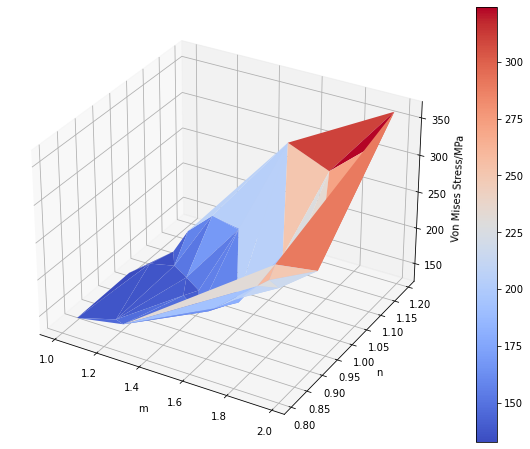

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

surface = ax.plot_trisurf(df['m'], df['n'], df['vm_stress/mpa'], cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel('m')
ax.set_ylabel('n')
ax.set_zlabel('Von Mises Stress/MPa')
fig.colorbar(surface)
plt.show()

# Fitting Kriging Model

In [5]:
from pykrige.ok import OrdinaryKriging

In [6]:
# Kriging interpolation to model vm_stress, volume and mass as a function of (m, n)
stress_model = OrdinaryKriging(
    df['m'].values,
    df['n'].values,
    df['vm_stress/mpa'].values,
    variogram_model='linear'
)

volume_model = OrdinaryKriging(
    df['m'].values,
    df['n'].values,
    df['volume/cm3'].values,
    variogram_model='linear'
)

mass_model = OrdinaryKriging(
    df['m'].values,
    df['n'].values,
    df['mass/g'].values,
    variogram_model='linear'
)

In [7]:
stress_model.execute('points', 1.5, 1.2)

(masked_array(data=[281.40126602172785],
              mask=[False],
        fill_value=1e+20),
 masked_array(data=[403.51551189513276],
              mask=[False],
        fill_value=1e+20))

In [8]:
volume_model.execute('points', 1.5, 1.2)

(masked_array(data=[153.1974566846785],
              mask=[False],
        fill_value=1e+20),
 masked_array(data=[9.633343612886568],
              mask=[False],
        fill_value=1e+20))

In [9]:
mass_model.execute('points', 1.5, 1.2)

(masked_array(data=[117.27298536377593],
              mask=[False],
        fill_value=1e+20),
 masked_array(data=[4.005322974982829],
              mask=[False],
        fill_value=1e+20))

# Feature Engineering

We need to define a feature to be optimized. The motivation of this optimization problem is to determine the geometry for the vessel's ends to maximize the amount of helium propellant that can be stored. Rearranging the ideal gas law gives

\begin{equation}
    m = \frac{PV}{RT}.
\end{equation}

We wish to quantify the improvement of a super ellipsoidal pressure vessel over a typical hemispherical one. We define a parameter known as the *improvement factor*, written as

\begin{equation}
    IF = \frac{m_{s}}{m_{h}} = \frac{P_s V_s / RT}{P_h V_h / RT} = \frac{P_s}{P_h} \cdot \frac{V_s}{V_h},
\end{equation}

where the $s$ and $h$ subscripts denote the superellipsoidal and hemispherical pressure vessels respectively. Note that $m$ refers to the theoretical mass of *helium* which the tank would store, not to the mass of the tank itself.

We've already determined the storage capacity of each of the above configurations. We can take the Von Mises stress as a proxy for the actual operating pressure, since this is a dimensionless variable normalized by that of the hemispherical pressure vessel. But bear in mind that we have an inverse relationship between the Von Mises stress and allowable pressure:

\begin{equation}
    P_{\text{allow}} \propto \frac{1}{\sigma_{\text{vm}}}
\end{equation}

Therefore, we rewrite equation (4) to give

\begin{equation}
    IF = \frac{\sigma_{h, \text{vm}}}{\sigma_{s, \text{vm}}} \cdot \frac{V_s}{V_h},
\end{equation}

We should also bear in mind that, ideally, we want the propellant tank to be as light as possible. Therefore, I introduce a penalty/ regularisation term which relates to the mass of the tank:

\begin{equation}
    IF = \left(\frac{m_{s}}{m_{h}}\right)_{\text{propellant}} - \alpha \cdot \left(\frac{m_s}{m_h}\right)_{\text{tank}}
\end{equation}

where $\alpha$ is a weight coefficient which can be tuned - increasing the value of $\alpha$ means penalizing higher tank masses more heavily. Finally, the full expression is:

\begin{equation}
    IF = \frac{\sigma_{h, \text{vm}}}{\sigma_{s, \text{vm}}} \cdot \frac{V_s}{V_h} - \alpha \cdot \left(\frac{m_s}{m_h}\right)_{\text{tank}}
\end{equation}

# Optimization

I'll be making use of `scipy.optimize.basinhopping`, which *minimizes* functions. Therefore, my `improvement_factor()` function should return $-IF$. Basin-hopping is a global stepping algorithm which performs local minimization at each step.

In [10]:
from scipy.optimize import basinhopping

In [11]:
def improvement_factor(params, vh, sh, mh, alpha):
    m, n = params
    ss = stress_model.execute('points', m, n)[0][0]
    vs = volume_model.execute('points', m, n)[0][0]
    ms = mass_model.execute('points', m, n)[0][0]
    IF = ((sh / ss) * (vs / vh) - alpha * (ms / mh))
    return -IF

In [12]:
# Get hemisphere values: m = 1.0 and n = 1.0
volume_hemisphere = df.iloc[0]['volume/cm3']
sigma_hemisphere = df.iloc[0]['vm_stress/mpa']
mass_hemisphere = df.iloc[0]['mass/g']

# Initial guess
x0 = [1.0, 1.0]

# Number of iterations
niter = 30

# Bounds
bounds = [(1.0, 2.0), (0.8, 1.2)]

# Penalty term
alpha = 0.02

minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'args': (volume_hemisphere, sigma_hemisphere, mass_hemisphere, alpha)
}

result = basinhopping(
    improvement_factor,
    niter=niter,
    x0=x0,
    minimizer_kwargs=minimizer_kwargs
)

In [13]:
m_optimal, n_optimal = result.x

In [14]:
m_optimal, n_optimal

(1.1372395911987507, 1.022420864161912)